In [ ]:
#@title Copyright 2023 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Colabs

Machine Learning Crash Course uses Colaboratories (Colabs) for all programming exercises. Colab is Google's implementation of [Jupyter Notebook](https://jupyter.org/). For more information about Colabs and how to use them, go to [Welcome to Colaboratory](https://research.google.com/colaboratory).

# Linear Regression
In this Colab you will use a real dataset to train a model to predict the fare of a taxi ride in Chicago, Illinois.

## Learning Objectives
After completing this Colab, you'll be able to:

  * Read a .csv file into a [pandas](https://developers.google.com/machine-learning/glossary/#pandas) DataFrame.
  * Explore a [dataset](https://developers.google.com/machine-learning/glossary/#data_set) with Python visualization libraries.
  * Experiment with different [features](https://developers.google.com/machine-learning/glossary/#feature) to build a linear regression model.
  * Tune the model's [hyperparameters](https://developers.google.com/machine-learning/glossary/#hyperparameter).
  * Compare training runs using [root mean squared error](https://developers.google.com/machine-learning/glossary/#root-mean-squared-error-rmse) and [loss curves](https://developers.google.com/machine-learning/glossary/#loss-curve).

## Dataset Description
The [dataset for this exercise](https://storage.mtls.cloud.google.com/mlcc-nextgen-internal/chicago_taxi_train.csv) is derived from the [City of Chicago Taxi Trips dataset](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew). The data for this exercise is a subset of the Taxi Trips data, and focuses on a two-day period in May of 2022.

# Part 1 - Setup Exercise


---

## Load required modules

This exercise depends on several Python libraries to help with data manipulation, machine learning tasks, and data visualization.

**Instructions**
1. Run the **Install required libraries** code cell (below).
1. Run the **Load dependencies** code cell (below).

In [ ]:
#@title Install required libraries

!pip install google-ml-edu==0.1.3 \
  keras~=3.8.0 \
  matplotlib~=3.10.0 \
  numpy~=2.0.0 \
  pandas~=2.2.0 \
  tensorflow~=2.18.0

print('\n\nAll requirements successfully installed.')

In [ ]:
#@title Code - Load dependencies

# data
import numpy as np
import pandas as pd

# machine learning
import keras
import ml_edu.experiment
import ml_edu.results

# data visualization
import plotly.express as px

## Load the dataset


The following code cell loads the dataset and creates a pandas DataFrame.

You can think of a DataFrame like a spreadsheet with rows and columns. The rows represent individual data examples, and the columns represent the attributes associated with each example.

In [ ]:
# @title
chicago_taxi_dataset = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/chicago_taxi_train.csv")

## Update the dataframe

The following code cell updates the DataFrame to use only specific columns from the dataset.

Notice that that output shows just a sample of the dataset, but there should be enough information for you to identify the features associated with the dataset, and have a look at the actual data for a few examples.

In [ ]:
#@title Code - Read dataset

# Updates dataframe to use specific columns.
training_df = chicago_taxi_dataset.loc[:, ('TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE')]

print('Read dataset completed successfully.')
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.head(200)

# Part 2 - Dataset Exploration


---

## View dataset statistics

A large part of most machine learning projects is getting to know your data. In this step, you will use the ``DataFrame.describe`` method to view descriptive statistics about the dataset and answer some important questions about the data.

**Instructions**
1. Run the **View dataset statistics** code cell.
1. Inspect the output and answer these questions:
  * What is the maximum fare?
  * What is the mean distance across all trips?
  * How many cab companies are in the dataset?
  * What is the most frequent payment type?
  * Are any features missing data?
1. Run the code **View answers to dataset statistics** code cell to check your answers.


You might be wondering why there are groups of `NaN` (not a number) values listed in the output. When working with data in Python, you may see this value if the result of a calculation can not be computed or if there is missing information. For example, in the taxi dataset `PAYMENT_TYPE` and `COMPANY` are non-numeric, categorical features; numeric information such as mean and max do not make sense for categorical features so the output displays `NaN`.

In [ ]:
#@title Code - View dataset statistics

print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.describe(include='all')

In [ ]:
#@title Double-click or run to view answers about dataset statistics

answer = '''
What is the maximum fare? 				              Answer: $159.25
What is the mean distance across all trips? 		Answer: 8.2895 miles
How many cab companies are in the dataset? 		  Answer: 31
What is the most frequent payment type? 		    Answer: Credit Card
Are any features missing data? 				          Answer: No
'''

# You should be able to find the answers to the questions about the dataset
# by inspecting the table output after running the DataFrame describe method.
#
# Run this code cell to verify your answers.

# What is the maximum fare?
max_fare = training_df['FARE'].max()
print("What is the maximum fare? 				Answer: ${fare:.2f}".format(fare = max_fare))

# What is the mean distance across all trips?
mean_distance = training_df['TRIP_MILES'].mean()
print("What is the mean distance across all trips? 		Answer: {mean:.4f} miles".format(mean = mean_distance))

# How many cab companies are in the dataset?
num_unique_companies =  training_df['COMPANY'].nunique()
print("How many cab companies are in the dataset? 		Answer: {number}".format(number = num_unique_companies))

# What is the most frequent payment type?
most_freq_payment_type = training_df['PAYMENT_TYPE'].value_counts().idxmax()
print("What is the most frequent payment type? 		Answer: {type}".format(type = most_freq_payment_type))

# Are any features missing data?
missing_values = training_df.isnull().sum().sum()
print("Are any features missing data? 				Answer:", "No" if missing_values == 0 else "Yes")

## Generate a correlation matrix

An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). If you have ever taken a taxi ride before, your experience is probably telling you that the fare is typically associated with the distance traveled and the duration of the trip. But, is there a way for you to learn more about how well these features correlate to the fare (label)?

In this step, you will use a **correlation matrix** to identify features whose values correlate well with the label. Correlation values have the following meanings:

  * **`1.0`**: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
  * **`-1.0`**: perfect negative correlation; that is, when one attribute rises, the other attribute falls.
  * **`0.0`**: no correlation; the two columns [are not linearly related](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).

In general, the higher the absolute value of a correlation value, the greater its predictive power.

**Instructions**

1. Inspect the code in the **View correlation matrix** code cell.
1. Run the **View correlation matrix** code cell and inspect the output.
1. **Check your understanding** by answering these questions:
  * Which feature correlates most strongly to the label FARE?
  * Which feature correlates least strongly to the label FARE?


In [ ]:
#@title Code - View correlation matrix
training_df.corr(numeric_only = True)

In [ ]:
#@title Double-click to view answers about the correlation matrix

# Which feature correlates most strongly to the label FARE?
# ---------------------------------------------------------
answer = '''
The feature with the strongest correlation to the FARE is TRIP_MILES.
As you might expect, TRIP_MILES looks like a good feature to start with to train
the model. Also, notice that the feature TRIP_SECONDS has a strong correlation
with fare too.
'''
print(answer)


# Which feature correlates least strongly to the label FARE?
# -----------------------------------------------------------
answer = '''The feature with the weakest correlation to the FARE is TIP_RATE.'''
print(answer)

## Visualize relationships in dataset

Sometimes it is helpful to visualize relationships between features in a dataset; one way to do this is with a pair plot. A **pair plot** generates a grid of pairwise plots to visualize the relationship of each feature with all other features all in one place.

**Instructions**
1. Run the **View pair plot** code cell.

In [ ]:
#@title Code - View pairplot
px.scatter_matrix(training_df, dimensions=["FARE", "TRIP_MILES", "TRIP_SECONDS"])

# Part 3 - Train Model


---

## Define functions to build and train a model

The code you need to build and train your model is in the **Define ML functions** code cell. If you would like to explore this code, expand the code cell and take a look.

**Instructions**
1. Run the **Define ML functions** code cell.

In [ ]:
#@title Code - Define ML functions

def create_model(
    settings: ml_edu.experiment.ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple linear regression model."""
  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  inputs = {name: keras.Input(shape=(1,), name=name) for name in settings.input_features}
  concatenated_inputs = keras.layers.Concatenate()(list(inputs.values()))
  outputs = keras.layers.Dense(units=1)(concatenated_inputs)
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model topography into code that Keras can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=settings.learning_rate),
                loss="mean_squared_error",
                metrics=metrics)

  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    label_name: str,
    settings: ml_edu.experiment.ExperimentSettings,
) -> ml_edu.experiment.Experiment:
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  features = {name: dataset[name].values for name in settings.input_features}
  label = dataset[label_name].values
  history = model.fit(x=features,
                      y=label,
                      batch_size=settings.batch_size,
                      epochs=settings.number_epochs)

  return ml_edu.experiment.Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )

print("SUCCESS: defining linear regression functions complete.")

## Train a model with one feature

In this step you will train a model to predict the cost of the fare using a **single feature**. Earlier, you saw that `TRIP_MILES` (distance) correlates most strongly with the ``FARE``, so let's start with `TRIP_MILES` as the feature for your first training run.

**Instructions**

1. Run the **Experiment 1** code cell to build your model with one feature.
1. Review the output from the training run
1. **Check your understanding** by answering these questions:
  * How many epochs did it take to converge on the final model?
  * How well does the model fit the sample data?

During training, you should see the root mean square error (RMSE) in the output. The units for RMSE are the same as the units for the label (dollars). In other words, you can use the RMSE to determine how far off, on average, the predicted fares are in dollars from the observed values.

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1675.3093 - rmse: 40.9102
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1118.1394 - rmse: 33.4193
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 680.1753 - rmse: 26.0602
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 364.6133 - rmse: 19.0625
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 141.6830 - rmse: 11.8676
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 32.8703 - rmse: 5.7055
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.6027 - rmse: 3.9480
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.2837 - rmse: 3.9031
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.6580 - rmse: 3.7989
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.4754 - rmse: 3.6595
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.3142 - rmse: 3.6409
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.1445 - rm

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


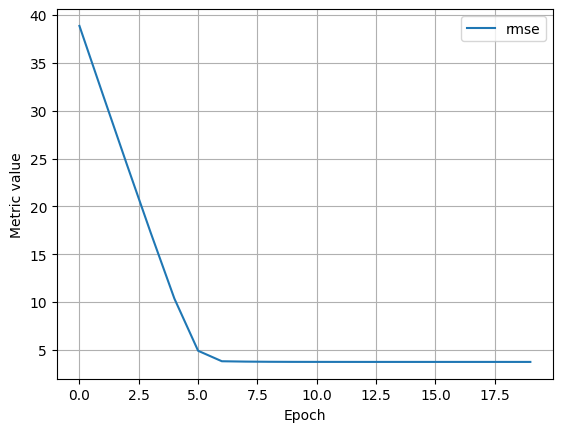

In [21]:
#@title Code - Experiment 1

# The following variables are the hyperparameters.
settings_1 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES']
)

metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

model_1 = create_model(settings_1, metrics)

experiment_1 = train_model('one_feature', model_1, training_df, 'FARE', settings_1)

ml_edu.results.plot_experiment_metrics(experiment_1, ['rmse'])
ml_edu.results.plot_model_predictions(experiment_1, training_df, 'FARE')

In [ ]:
#@title Double-click to view answers for training model with one feature

# How many epochs did it take to converge on the final model?
# -----------------------------------------------------------------------------
answer = """
Use the loss curve to see where the loss begins to level off during training.

With this set of hyperparameters:

  learning_rate = 0.001
  epochs = 20
  batch_size = 50

it takes about 5 epochs for the training run to converge to the final model.
"""
print(answer)

# How well does the model fit the sample data?
# -----------------------------------------------------------------------------
answer = '''
It appears from the model plot that the model fits the sample data fairly well.
'''
print(answer)

## Experiment with hyperparameters

It is common with machine learning to run multiple experiments to find the best set of hyperparmeters to train your model. In this step, try varying the hyperparameters one by one with this set of experiments:

* *Experiment 1:* **Increase** the learning rate to **``1.0``** (batch size at ``50``).
* *Experiment 2:* **Decrease** the learning rate to **``0.0001``** (batch size at ``50``).
* *Experiment 3:* **Increase** the batch size to **``500``** (learning rate at ``0.001``).

**Instructions**
1. Update the hyperparameter values in the **Experiment 2** code cell according to the experiment.
2. Run the **Experiment 2** code cell.
3. After the training run, examine the output and note any differences you see in the loss curve or model output.
4. Repeat steps 1 - 3 for each hyperparameter experiment.
5. **Check your understanding** by answering these questions:
  * How did raising the learning rate impact your ability to train the model?
  * How did lowering the learning rate impact your ability to train the model?
  * Did changing the batch size effect your training results?


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 263.4414 - rmse: 16.2297
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 236.5120 - rmse: 15.3788
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 217.9433 - rmse: 14.7623
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 197.3499 - rmse: 14.0466
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177.4859 - rmse: 13.3219
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161.8061 - rmse: 12.7187
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140.5383 - rmse: 11.8545
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127.2254 - rmse: 11.2781
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.1306 - rmse: 10.5410
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94.7763 - rmse: 9.7352
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84.7820 - rmse: 9.2073
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74.1955 - rmse: 8.6118
Epoch 1

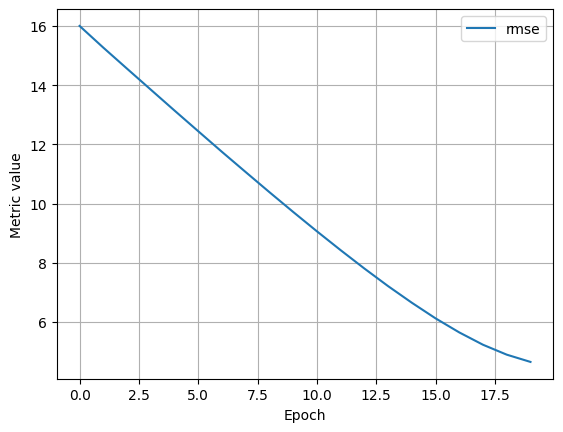

In [23]:
#@title Code - Experiment 2

# The following variables are the hyperparameters.
# TODO - Adjust these hyperparameters to see how they impact a training run.
settings_2 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,
    number_epochs = 20,
    batch_size = 500,
    input_features = ['TRIP_MILES']
)

metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

model_2 = create_model(settings_2, metrics)

experiment_2 = train_model('one_feature_hyper', model_2, training_df, 'FARE', settings_2)

ml_edu.results.plot_experiment_metrics(experiment_2, ['rmse'])
ml_edu.results.plot_model_predictions(experiment_2, training_df, 'FARE')

In [24]:
#@title Double-click to view answers for hyperparameter experiments

# How did raising the learning rate impact your ability to train the model?
# -----------------------------------------------------------------------------
answer = """
When the learning rate is too high, the loss curve bounces around and does not
appear to be moving towards convergence with each iteration. Also, notice that
the predicted model does not fit the data very well. With a learning rate that
is too high, it is unlikely that you will be able to train a model with good
results.
"""
print(answer)

# How did lowering the learning rate impact your ability to train the model?
# -----------------------------------------------------------------------------
answer = '''
When the learning rate is too small, it may take longer for the loss curve to
converge. With a small learning rate the loss curve decreases slowly, but does
not show a dramatic drop or leveling off. With a small learning rate you could
increase the number of epochs so that your model will eventually converge, but
it will take longer.
'''
print(answer)

# Did changing the batch size effect your training results?
# -----------------------------------------------------------------------------
answer = '''
Increasing the batch size makes each epoch run faster, but as with the smaller
learning rate, the model does not converge with just 20 epochs. If you have
time, try increasing the number of epochs and eventually you should see the
model converge.
'''
print(answer)


When the learning rate is too high, the loss curve bounces around and does not
appear to be moving towards convergence with each iteration. Also, notice that
the predicted model does not fit the data very well. With a learning rate that
is too high, it is unlikely that you will be able to train a model with good
results.


When the learning rate is too small, it may take longer for the loss curve to
converge. With a small learning rate the loss curve decreases slowly, but does
not show a dramatic drop or leveling off. With a small learning rate you could
increase the number of epochs so that your model will eventually converge, but
it will take longer.


Increasing the batch size makes each epoch run faster, but as with the smaller
learning rate, the model does not converge with just 20 epochs. If you have
time, try increasing the number of epochs and eventually you should see the
model converge.



## Train a model with two features

The model you trained with the feature ``TOTAL_MILES`` demonstrates fairly strong predictive power, but is it possible to do better? In this step, try training the model with two features, ``TRIP_MILES`` and ``TRIP_MINUTES``, to see if you can improve the model. You may recall that the original dataset does not include a feature ``TRIP_MINUTES``, but this feature can be easily derived from ``TRIP_SECONDS`` as shown in the code below.*

**Instructions**
1. Review the code in **Experiment 3** code cell.
1. Run the **Experiment 3** code cell.
1. Review the output from the training run and answer these questions:
  * Does the model with two features produce better results than one using a single feature?
  * Does it make a difference if you use ``TRIP_SECONDS`` instead of ``TRIP_MINUTES``?
  * How well do you think the model comes to the ground truth fare calculation for Chicago Taxi Trips?


Notice that the scatter plot of the features vs. the label is a three dimensional (3-D) plot. This representation allows you to visualize both features and the label all together. The two features (TRIP_MILES and TRIP_MINUTES) are on the x and y axis, and the label (FARE) is on the z axis. The plot shows individual examples in the dataset as circles, and the model as a surface (plane). With this 3-D model, if the trained model is good you would expect most of the examples to land on the plane surface. The 3-D plot is interactive so you can explore the data further by clicking or dragging the plot.

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1797.0940 - rmse: 42.2630
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 411.6318 - rmse: 20.1237
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 77.2022 - rmse: 8.7805
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50.4601 - rmse: 7.0977
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 28.8908 - rmse: 5.3666
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.6895 - rmse: 4.2036
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.9501 - rmse: 3.7306
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.9159 - rmse: 3.5890
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13.0010 - rmse: 3.5969
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.6153 - rmse: 3.4052
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.6121 - rmse: 3.4031
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.3609 - rmse: 3.3

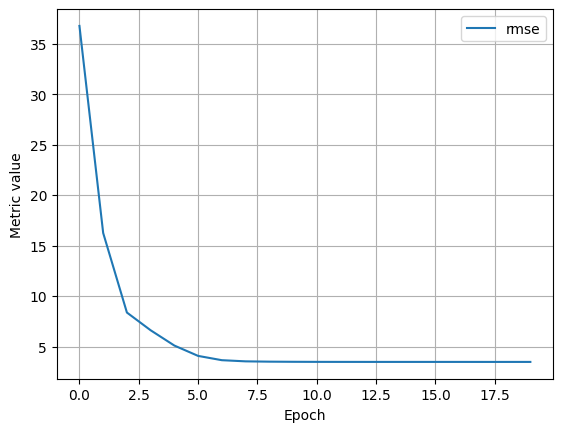

In [25]:
#@title Code - Experiment 3

# The following variables are the hyperparameters.
settings_3 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES', 'TRIP_MINUTES']
)

training_df['TRIP_MINUTES'] = training_df['TRIP_SECONDS']/60

metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

model_3 = create_model(settings_3, metrics)

experiment_3 = train_model('two_features', model_3, training_df, 'FARE', settings_3)

ml_edu.results.plot_experiment_metrics(experiment_3, ['rmse'])
ml_edu.results.plot_model_predictions(experiment_3, training_df, 'FARE')

In [ ]:
#@title Double-click to view answers for training with two features

# Does the model with two features produce better results than one using a
# single feature?
# -----------------------------------------------------------------------------
answer = '''
To answer this question for your specific training runs, compare the RMSE for
each model. For example, if the RMSE for the model trained with one feature was
3.7457 and the RMSE for the model with two features is 3.4787, that means that
on average the model with two features makes predictions that are about $0.27
closer to the observed fare.

'''
print(answer)

# Does it make a difference if you use TRIP_SECONDS instead of TRIP_MINUTES?
# -----------------------------------------------------------------------------
answer = '''
When training a model with more than one feature, it is important that all
numeric values are roughly on the same scale. In this case, TRIP_SECONDS and
TRIP_MILES do not meet this criteria. The mean value for TRIP_MILES is 8.3 and
the mean for TRIP_SECONDS is 1,320; that is two orders of magnitude difference.
In contrast, the mean for TRIP_MINUTES is 22, which is more similar to the scale
of TRIP_MILES (8.3) than TRIP_SECONDS (1,320). Of course, this is not the
only way to scale values before training, but you will learn about that in
another module.
'''
print(answer)

# How well do you think the model comes to the ground truth fare calculation for
# Chicago taxi trips?
# -----------------------------------------------------------------------------
answer = '''
In reality, Chicago taxi cabs use a documented formula to determine cab fares.
For a single passenger paying cash, the fare is calculated like this:

FARE = 2.25 * TRIP_MILES + 0.12 * TRIP_MINUTES + 3.25

Typically with machine learning problems you would not know the 'correct'
formula, but in this case you can use this knowledge to evaluate your model.
Take a look at your model output (the weights and bias) and determine how
well it matches the ground truth fare calculation. You should find that the
model is roughly close to this formula.
'''
print(answer)

## Compare Experiments

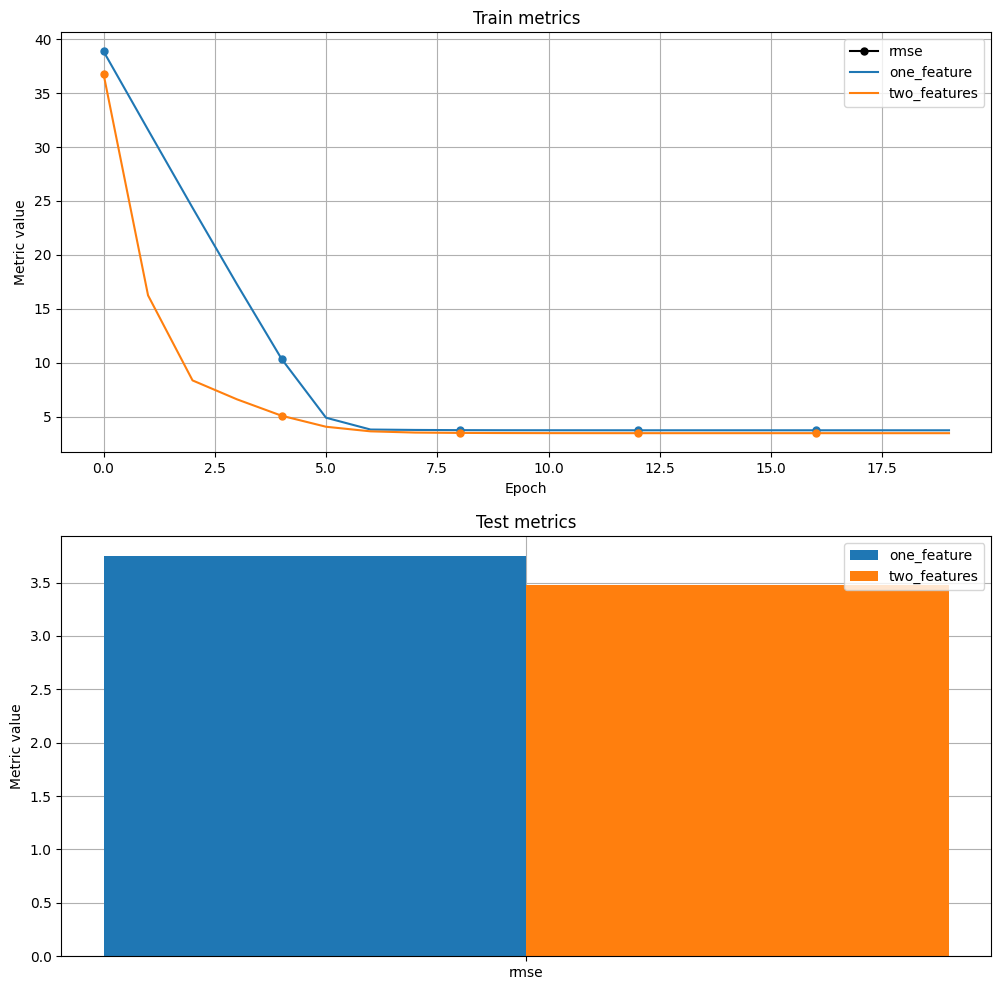

In [26]:
ml_edu.results.compare_experiment([experiment_1, experiment_3], ['rmse'], training_df, training_df['FARE'].values)

# Part 4 - Validate Model


---

## Use the model to make predictions

Now that you have a trained model, you can use the model to make predictions. In practice, you should make predictions on examples that are not used during training. However, for this exercise, you'll just work with a subset of the same training dataset. In another Colab exercise you will explore ways to make predictions on examples not used in training.

**Instructions**

1. Run the **Define functions to make predictions** code cell.
1. Run the **Make predictions** code cell.
1. Review the predictions in the output.
1. **Check your understanding** by answering these questions:
  * How close is the predicted value to the label value? In other words, does your model accurately predict the fare for a taxi ride?

In [27]:
#@title Code - Define functions to make predictions
def format_currency(x):
  return "${:.2f}".format(x)

def build_batch(df, batch_size):
  batch = df.sample(n=batch_size).copy()
  batch.set_index(np.arange(batch_size), inplace=True)
  return batch

def predict_fare(model, df, features, label, batch_size=50):
  batch = build_batch(df, batch_size)
  predicted_values = model.predict_on_batch(x={name: batch[name].values for name in features})

  data = {"PREDICTED_FARE": [], "OBSERVED_FARE": [], "L1_LOSS": [],
          features[0]: [], features[1]: []}
  for i in range(batch_size):
    predicted = predicted_values[i][0]
    observed = batch.at[i, label]
    data["PREDICTED_FARE"].append(format_currency(predicted))
    data["OBSERVED_FARE"].append(format_currency(observed))
    data["L1_LOSS"].append(format_currency(abs(observed - predicted)))
    data[features[0]].append(batch.at[i, features[0]])
    data[features[1]].append("{:.2f}".format(batch.at[i, features[1]]))

  output_df = pd.DataFrame(data)
  return output_df

def show_predictions(output):
  header = "-" * 80
  banner = header + "\n" + "|" + "PREDICTIONS".center(78) + "|" + "\n" + header
  print(banner)
  print(output)
  return

In [28]:
#@title Code - Make predictions

output = predict_fare(experiment_3.model, training_df, experiment_3.settings.input_features, 'FARE')
show_predictions(output)

--------------------------------------------------------------------------------
|                                 PREDICTIONS                                  |
--------------------------------------------------------------------------------
   PREDICTED_FARE OBSERVED_FARE L1_LOSS  TRIP_MILES TRIP_MINUTES
0           $9.16         $8.75   $0.41        1.90        10.00
1           $5.28         $4.50   $0.78        0.50         3.00
2          $31.44        $31.25   $0.19       11.91        23.50
3           $8.25         $7.75   $0.50        1.60         8.00
4          $33.53        $36.37   $2.84       12.96        23.27
5           $8.32         $7.75   $0.57        1.67         7.48
6          $47.09        $47.25   $0.16       17.99        45.92
7          $16.04        $16.96   $0.92        5.36         9.15
8          $28.80        $28.25   $0.55        9.59        37.33
9           $5.77         $5.00   $0.77        0.82         1.92
10          $7.19         $7.00   $0.19   

In [ ]:
#@title Double-click to view answers for validate model

# How close is the predicted value to the label value?
# -----------------------------------------------------------------------------
answer = '''
Based on a random sampling of examples, the model seems to do pretty well
predicting the fare for a taxi ride. Most of the predicted values do not vary
significantly from the observed value. You should be able to see this by looking
at the column L1_LOSS = |observed - predicted|.
'''
print(answer)